# Equity Embeddings Explorer

This notebook provides interactive exploration of the 16-dimensional equity embeddings.

## What are these embeddings?

The autoencoder has compressed ~72 features (financial ratios + sector info) into 16 dimensions that capture the "essence" of each company's financial health and structure.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sys
sys.path.append('..')
from src.search import EquitySearch

# Load data
embeddings_df = pd.read_csv('../data/processed/embeddings.csv', index_col=0)
features_df = pd.read_csv('../data/processed/processed_features.csv', index_col=0)

print(f"Loaded {len(embeddings_df)} companies")
print(f"Embedding dimensions: {embeddings_df.shape[1]}")
print(f"Feature dimensions: {features_df.shape[1]}")

Loaded 435 companies
Embedding dimensions: 16
Feature dimensions: 28


In [5]:
# Load company metadata
import simfin as sf
import os
from dotenv import load_dotenv

load_dotenv()
sf.set_api_key(os.getenv('SIMFIN_API_KEY'))
sf.set_data_dir('../data/simfin_cache')

companies = sf.load_companies(market='us')
if companies.index.name == 'Ticker':
    companies = companies.reset_index()
companies.columns = [c.lower() for c in companies.columns]

# Align with embeddings
metadata = companies[companies['ticker'].isin(embeddings_df.index)].copy()
metadata = metadata.set_index('ticker').reindex(embeddings_df.index).reset_index()

metadata.head()

Dataset "us-companies" on disk (2 days old).
- Loading from disk ... Done!


/opt/anaconda3/lib/python3.13/site-packages/simfin/load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


,Ticker,simfinid,company name,industryid,isin,end of financial year (month),number employees,business summary,market,cik,main currency
0,A,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD
1,AAPL,111052,APPLE INC,101001.0,US0378331005,9.0,147000.0,Apple Inc is an American multinational technol...,us,320193.0,USD
2,ABBV,61199,AbbVie Inc.,106005.0,US00287Y1091,12.0,2020.0,AbbVie Inc is a biopharmaceutical company that...,us,1551152.0,USD
3,ABNB,1214552,"Airbnb, Inc.",103015.0,US0090661010,12.0,5597.0,Airbnb is a community based on connection and ...,us,1559720.0,USD
4,ABT,63877,ABBOTT LABORATORIES,106004.0,US0028241000,12.0,109000.0,Abbott Laboratories is a health care company t...,us,1800.0,USD


## 1. Query Similar Companies

In [6]:
# Create search engine
search_engine = EquitySearch(embeddings_df.values, metadata)

# Query a ticker
ticker = 'AAPL'
analysis = search_engine.analyze_ticker(ticker, k=10)

print(f"\n{'='*70}")
print(f"Analyzing: {ticker}")
print(f"{'='*70}\n")

print("\nMOST SIMILAR COMPANIES:")
display(analysis['most_similar'][['ticker', 'name', 'distance']])

print("\nLEAST SIMILAR COMPANIES:")
display(analysis['least_similar'][['ticker', 'name', 'distance']])

ValueError: Metadata must contain 'ticker' column.

## 2. Visualize Embedding Space with PCA

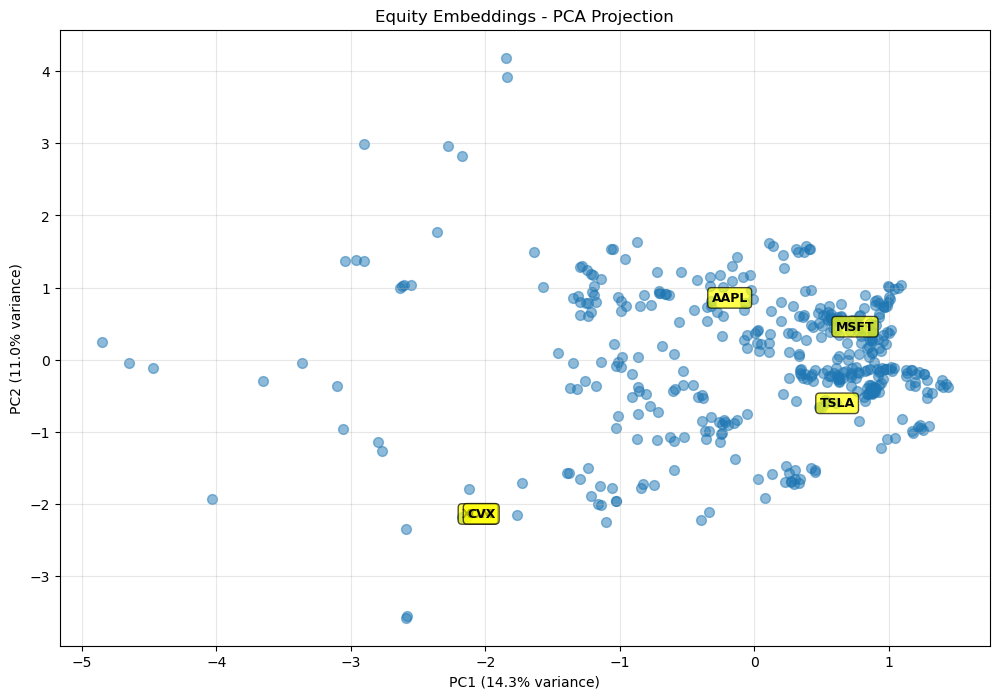

Total variance explained by 2 PCs: 25.3%


In [ ]:
# PCA to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_df.values)

# Create DataFrame
plot_df = pd.DataFrame({
    'PC1': embeddings_2d[:, 0],
    'PC2': embeddings_2d[:, 1],
    'ticker': embeddings_df.index
})

plt.figure(figsize=(12, 8))
plt.scatter(plot_df['PC1'], plot_df['PC2'], alpha=0.5, s=50)

# Annotate a few tickers
highlight = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'JPM', 'BAC', 'XOM', 'CVX']
for ticker in highlight:
    if ticker in plot_df['ticker'].values:
        row = plot_df[plot_df['ticker'] == ticker].iloc[0]
        plt.annotate(ticker, (row['PC1'], row['PC2']), 
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Equity Embeddings - PCA Projection')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total variance explained by 2 PCs: {pca.explained_variance_ratio_.sum():.1%}")

## 3. Compare Two Companies

In [ ]:
def compare_companies(ticker1, ticker2):
    """Compare two companies in embedding space."""
    if ticker1 not in embeddings_df.index or ticker2 not in embeddings_df.index:
        print("One or both tickers not found")
        return
    
    emb1 = embeddings_df.loc[ticker1].values
    emb2 = embeddings_df.loc[ticker2].values
    
    # Calculate distance
    distance = np.linalg.norm(emb1 - emb2)
    
    # Get company names
    name1 = metadata[metadata['ticker'] == ticker1]['name'].iloc[0]
    name2 = metadata[metadata['ticker'] == ticker2]['name'].iloc[0]
    
    print(f"\n{ticker1} ({name1})")
    print(f"vs")
    print(f"{ticker2} ({name2})")
    print(f"\nEmbedding Distance: {distance:.4f}")
    
    # Compare features
    feat1 = features_df.loc[ticker1]
    feat2 = features_df.loc[ticker2]
    
    comparison = pd.DataFrame({
        ticker1: feat1,
        ticker2: feat2,
        'diff': feat1 - feat2
    })
    
    # Show top differences
    print("\nTop 5 Feature Differences:")
    top_diffs = comparison.iloc[comparison['diff'].abs().argsort()[-5:]]
    display(top_diffs)

# Example
compare_companies('AAPL', 'MSFT')

KeyError: 'ticker'

## 4. Find Companies in a Distance Range

In [ ]:
def find_companies_in_range(ticker, min_dist, max_dist):
    """Find companies within a specific distance range."""
    if ticker not in embeddings_df.index:
        print(f"Ticker {ticker} not found")
        return None
    
    query_emb = embeddings_df.loc[ticker].values
    distances = np.linalg.norm(embeddings_df.values - query_emb, axis=1)
    
    mask = (distances >= min_dist) & (distances <= max_dist)
    results = metadata[mask].copy()
    results['distance'] = distances[mask]
    results = results.sort_values('distance')
    
    return results[['ticker', 'name', 'distance']]

# Example: Find companies moderately similar to AAPL
print("Companies with moderate similarity to AAPL:")
display(find_companies_in_range('AAPL', min_dist=3.0, max_dist=5.0))

Companies with moderate similarity to AAPL:


KeyError: "['ticker', 'name'] not in index"

## 5. Clustering Companies

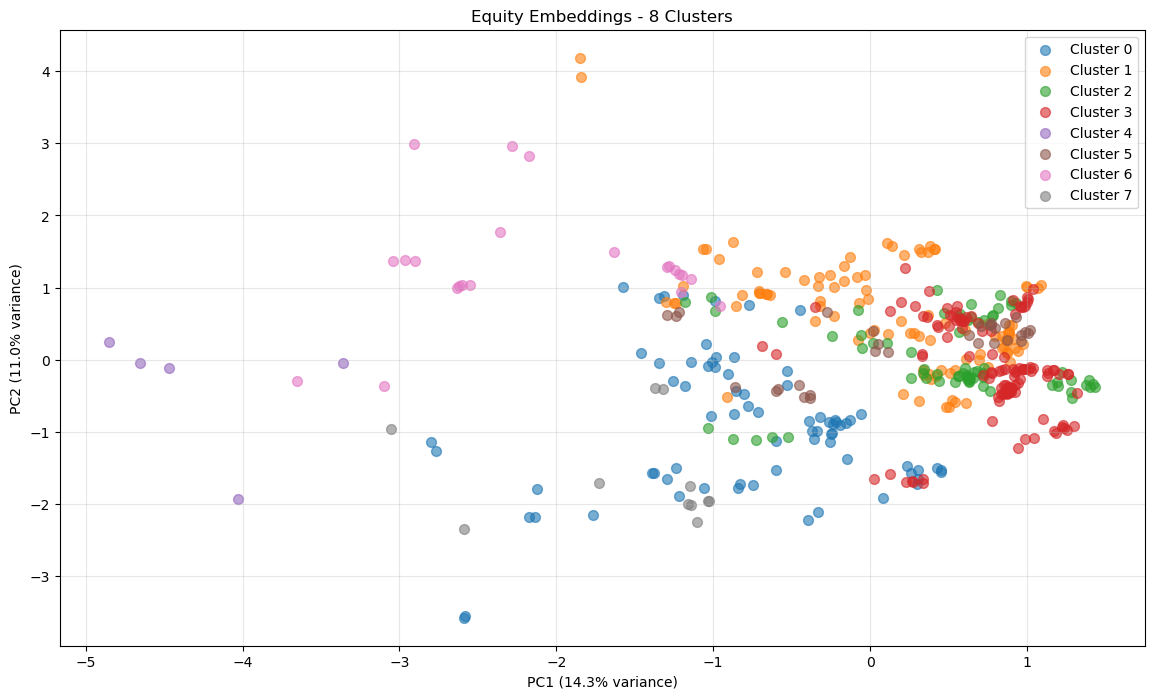


Cluster 0: AJG, ALLE, AMZN, AON, AZO, BAX, BBY, BDX, BLDR, BRO

Cluster 1: A, AAPL, ABT, AKAM, ALGN, AMP, ANET, APA, APH, APO

Cluster 2: ADI, ADP, AMAT, AMD, AME, AOS, AVGO, AVY, BR, CARR

Cluster 3: ABBV, ABNB, ADBE, ADM, ADSK, AEE, AEP, AES, ALB, AMT

Cluster 4: CAH, COR, HSIC, MCK, PCAR

Cluster 5: AMGN, AXON, BA, BIIB, CAT, DAL, DE, DIS, FOX, GD

Cluster 6: AMCR, BALL, CF, CTVA, DHI, EME, FAST, GNRC, GWW, IP

Cluster 7: ACN, CEG, CSCO, EG, HPE, LHX, MSI, OMC, RSG, SMCI


In [ ]:
from sklearn.cluster import KMeans

# Perform clustering
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_df.values)

# Add clusters to metadata
plot_df['cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(14, 8))
for i in range(n_clusters):
    mask = plot_df['cluster'] == i
    plt.scatter(plot_df[mask]['PC1'], plot_df[mask]['PC2'], 
               label=f'Cluster {i}', alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Equity Embeddings - {n_clusters} Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show companies in each cluster
for i in range(n_clusters):
    cluster_tickers = plot_df[plot_df['cluster'] == i]['ticker'].values[:10]
    print(f"\nCluster {i}: {', '.join(cluster_tickers)}")

## 6. Feature Importance Analysis

In [ ]:
# Correlation between original features and embeddings
from scipy.stats import spearmanr

# Calculate correlations
correlations = []
for feature in features_df.columns:
    for i in range(embeddings_df.shape[1]):
        corr, _ = spearmanr(features_df[feature], embeddings_df.iloc[:, i])
        correlations.append({
            'feature': feature,
            'embedding_dim': i,
            'correlation': abs(corr)
        })

corr_df = pd.DataFrame(correlations)

# Top correlations for each embedding dimension
print("Top features for each embedding dimension:\n")
for dim in range(min(5, embeddings_df.shape[1])):
    top = corr_df[corr_df['embedding_dim'] == dim].nlargest(3, 'correlation')
    print(f"Dimension {dim}:")
    for _, row in top.iterrows():
        print(f"  {row['feature']}: {row['correlation']:.3f}")
    print()

Top features for each embedding dimension:

Dimension 0:
  sector_101003.0: 0.318
  sector_109001.0: 0.302
  sector_101004.0: 0.273

Dimension 1:
  sector_103015.0: 0.275
  sector_100001.0: 0.268
  Net Profit Margin: 0.261

Dimension 2:
  Operating Margin: 0.499
  Asset Turnover: 0.486
  Gross Margin: 0.461

Dimension 3:
  Equity Ratio: 0.251
  sector_100001.0: 0.250
  sector_103015.0: 0.249

Dimension 4:
  ROA: 0.392
  Interest Coverage: 0.350
  Net Profit Margin: 0.331



/var/folders/hf/kdx80l7d1rg5r_cjbjvvnctr0000gn/T/ipykernel_55715/4229218895.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(features_df[feature], embeddings_df.iloc[:, i])
